In [20]:
import tensorflow as tf
import numpy as np
import pickle 
import time
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

# Traffic Sign Recognition Classifier

In [5]:
#Loading Data traffic-signs-data

training = "traffic-signs-data/train.p"
testing = "traffic-signs-data/test.p"


with open(training, mode='rb') as file:
    train = pickle.load(file) 

with open(testing, mode='rb') as file:
    test = pickle.load(file)



In [19]:
X_tr, Y_tr = train['features'], train['labels']
X_te, Y_te = test['features'], test['labels']
classes = len(set(Y_tr))


print ("Training iputs shape: {}".format(X_tr.shape))
print ("Training labels shape: {}".format(Y_tr.shape))

print ("Testing iputs shape: {}".format(X_te.shape))
print ("Testing labels shape: {}".format(Y_te.shape))
print ("Number of classes {}". format(classes))

Training iputs shape: (39209, 32, 32, 3)
Training labels shape: (39209,)
Testing iputs shape: (12630, 32, 32, 3)
Testing labels shape: (12630,)
Number of classes 43


# Visualizing Data

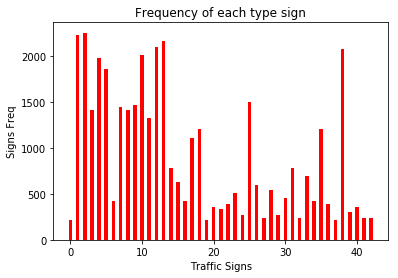

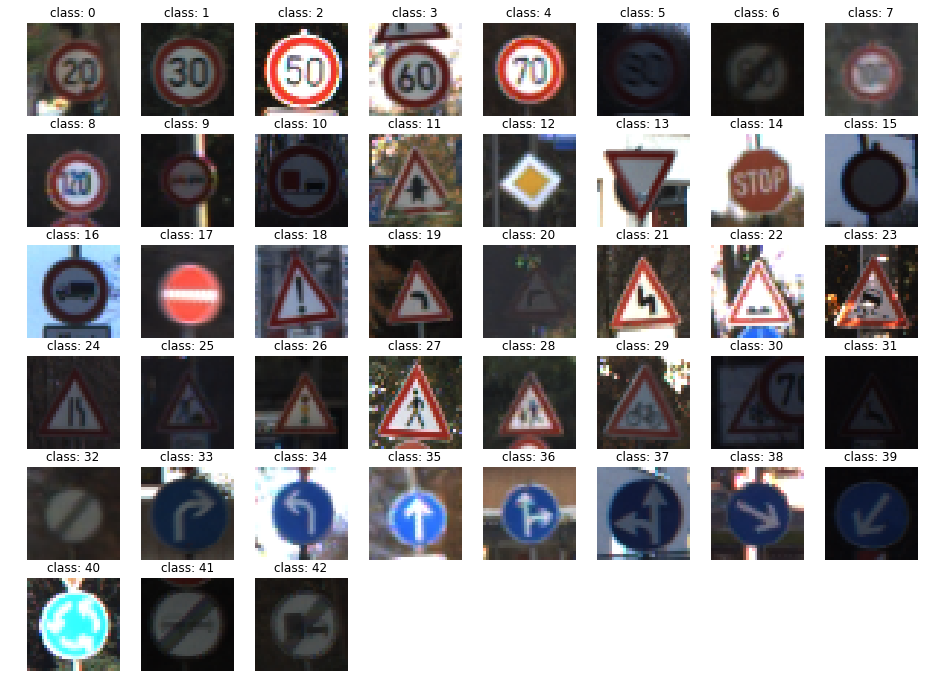

In [33]:
import random as rd

fig, ax = plt.subplots()
ax.bar(range(classes), np.bincount(Y_tr), 0.5, color='r')
ax.set_xlabel('Traffic Signs')
ax.set_ylabel('Signs Freq')
ax.set_title('Frequency of each type sign')
plt.show()

plt.figure(figsize=(16, 16))
for i in range(classes):
    j = rd.choice(np.where(Y_tr == i)[0])
    plt.subplot(8, 8, i + 1)
    plt.axis('off')
    plt.title('class: {}'.format(i))
    plt.imshow(X_tr[j])


